In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

warnings.filterwarnings('ignore')

In [2]:
# Machine learning model
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, f1_score, precision_score, recall_score, accuracy_score)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import SMOTE

In [3]:
file_path = 'Fraud.csv'  
df = pd.read_csv(file_path)

df.shape
print(f"Number of transactions: {df.shape[0]:,}")
print(f"Number of features: {df.shape[1]}")

Number of transactions: 1,048,575
Number of features: 11


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   step            1048575 non-null  int64  
 1   type            1048575 non-null  object 
 2   amount          1048575 non-null  float64
 3   nameOrig        1048575 non-null  object 
 4   oldbalanceOrg   1048575 non-null  float64
 5   newbalanceOrig  1048575 non-null  float64
 6   nameDest        1048575 non-null  object 
 7   oldbalanceDest  1048575 non-null  float64
 8   newbalanceDest  1048575 non-null  float64
 9   isFraud         1048575 non-null  int64  
 10  isFlaggedFraud  1048575 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 88.0+ MB


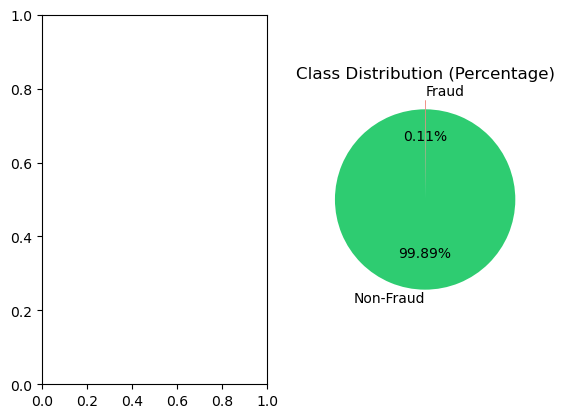

No missing values found!

Number of duplicate rows: 0


In [4]:
df.head(10)
df.info()
df.describe()

fraud_counts = df['isFraud'].value_counts()
fig, axes = plt.subplots(1, 2)
colors = ['#2ecc71', '#e74c3c']
axes[1].pie(fraud_counts.values, labels=['Non-Fraud', 'Fraud'], autopct='%1.2f%%',colors=colors, startangle=90, explode=(0, 0.1))
axes[1].set_title('Class Distribution (Percentage)')
plt.show()

missing_values = df.isnull().sum()
if missing_values.sum() == 0:
  print("No missing values found!")
else:
  print(missing_values[missing_values > 0])

duplicates = df.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicates}")

In [5]:
# handling missing values
df2 = df.copy()
numerical_cols = df2.select_dtypes(include=[np.number]).columns
for col in numerical_cols:
    if df2[col].isnull().sum() > 0:
        df2[col].fillna(df2[col].median(), inplace=True)

print(f"Missing values after handling: {df2.isnull().sum().sum()}")

#OUTLIER detection 
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return len(outliers), lower_bound, upper_bound

numerical_features = df2.select_dtypes(include=[np.number]).columns.tolist()
if 'isFraud' in numerical_features:
    numerical_features.remove('isFraud')
if 'isFlaggedFraud' in numerical_features:
    numerical_features.remove('isFlaggedFraud')

for col in numerical_features[:5]: 
    outlier_count, lower, upper = detect_outliers_iqr(df2, col)
    outlier_pct = (outlier_count / len(df2)) * 100
    print(f"  {col}: {outlier_count:,} outliers ({outlier_pct:.2f}%)")

df3 = df2.copy()

# Correlation matrix
numerical_data = df3.select_dtypes(include=[np.number])
correlation_matrix = numerical_data.corr()
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            high_corr_pairs.append({'Feature_1': correlation_matrix.columns[i],'Feature_2': correlation_matrix.columns[j],'Correlation':correlation_matrix.iloc[i, j]})

if high_corr_pairs:
    print("Highly correlated pairs (|r| > 0.8):")
    for pair in high_corr_pairs:
        print(f"  {pair['Feature_1']} <-> {pair['Feature_2']}: {pair['Correlation']:.3f}")
else:
    print("Not found")

def calculate_vif(df, features):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = features
    vif_data["VIF"] = [variance_inflation_factor(df[features].values, i) 
                       for i in range(len(features))]
    return vif_data.sort_values('VIF', ascending=False)

if len(numerical_features) > 1:
    vif_df = calculate_vif(df3, numerical_features[:min(10, len(numerical_features))])
    print(vif_df.head(10))

f"Cleaned shape: {df3.shape}"
print(df3)

Missing values after handling: 0
  step: 17,974 outliers (1.71%)
  amount: 53,088 outliers (5.06%)
  oldbalanceOrg: 181,877 outliers (17.35%)
  newbalanceOrig: 0 outliers (0.00%)
  oldbalanceDest: 125,403 outliers (11.96%)
Highly correlated pairs (|r| > 0.8):
  oldbalanceOrg <-> newbalanceOrig: 0.999
  oldbalanceDest <-> newbalanceDest: 0.978
          Feature         VIF
3  newbalanceOrig  605.700260
2   oldbalanceOrg  603.402550
5  newbalanceDest   40.318676
4  oldbalanceDest   37.639461
1          amount    1.833350
0            step    1.339832
         step      type     amount     nameOrig  oldbalanceOrg  \
0           1   PAYMENT    9839.64  C1231006815      170136.00   
1           1   PAYMENT    1864.28  C1666544295       21249.00   
2           1  TRANSFER     181.00  C1305486145         181.00   
3           1  CASH_OUT     181.00   C840083671         181.00   
4           1   PAYMENT   11668.14  C2048537720       41554.00   
...       ...       ...        ...          ...  

In [6]:
# Feature engineerin
df_features = df3.copy()

if 'amount' in df_features.columns:
    df_features['log_amount'] = np.log1p(df_features['amount'])
    df_features['amount_squared'] = df_features['amount'] ** 2

if 'oldbalanceOrg' in df_features.columns and 'newbalanceOrig' in df_features.columns:
    df_features['balance_change_orig'] = df_features['newbalanceOrig'] - df_features['oldbalanceOrg']
    df_features['balance_ratio_orig'] = df_features['newbalanceOrig'] / (df_features['oldbalanceOrg'] + 1)

if 'oldbalanceDest' in df_features.columns and 'newbalanceDest' in df_features.columns:
    df_features['balance_change_dest'] = df_features['newbalanceDest'] - df_features['oldbalanceDest']
    df_features['balance_ratio_dest'] = df_features['newbalanceDest'] / (df_features['oldbalanceDest'] + 1)

#Encode
categorical_columns = df_features.select_dtypes(include=['object']).columns
label_encoders = {}

for col in categorical_columns:
    if col not in ['nameOrig', 'nameDest']: 
        le = LabelEncoder()
        df_features[col] = le.fit_transform(df_features[col].astype(str))
        label_encoders[col] = le

df_features.shape[1]

columns_to_drop = ['isFraud', 'isFlaggedFraud']
if 'nameOrig' in df_features.columns:
    columns_to_drop.append('nameOrig')
if 'nameDest' in df_features.columns:
    columns_to_drop.append('nameDest')

X = df_features.drop(columns=[col for col in columns_to_drop if col in df_features.columns])
y = df_features['isFraud']
print(f"\nFeature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")


Feature matrix shape: (1048575, 13)
Target vector shape: (1048575,)


In [7]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"\nTrain set: {X_train.shape[0]:,} samples ({(X_train.shape[0]/len(X))*100:.1f}%)")
print(f"Test set: {X_test.shape[0]:,} samples ({(X_test.shape[0]/len(X))*100:.1f}%)")


Train set: 734,002 samples (70.0%)
Test set: 314,573 samples (30.0%)


In [8]:
#Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print(df_features)

         step  type     amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0           1     3    9839.64  C1231006815      170136.00       160296.36   
1           1     3    1864.28  C1666544295       21249.00        19384.72   
2           1     4     181.00  C1305486145         181.00            0.00   
3           1     1     181.00   C840083671         181.00            0.00   
4           1     3   11668.14  C2048537720       41554.00        29885.86   
...       ...   ...        ...          ...            ...             ...   
1048570    95     1  132557.35  C1179511630      479803.00       347245.65   
1048571    95     3    9917.36  C1956161225       90545.00        80627.64   
1048572    95     3   14140.05  C2037964975       20545.00         6404.95   
1048573    95     3   10020.05  C1633237354       90605.00        80584.95   
1048574    95     3   11450.03  C1264356443       80584.95        69134.92   

            nameDest  oldbalanceDest  newbalanceDest  isFraud  

In [9]:
models = {'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=20, class_weight='balanced', random_state=42, n_jobs=-1)}

for name in models.keys():
    print(f"{name}")

trained_models = {}
training_results = []
for name, model in models.items():
    print(f"\nTraining {name}...", end=" ")
    # Train
    model.fit(X_train_scaled, y_train)
    
    # Predict
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
    
    trained_models[name] = {'model': model,'y_pred': y_pred,'y_pred_proba': y_pred_proba}
    training_results.append({'Model': name,'Accuracy': accuracy,'Precision': precision,'Recall': recall,'F1-Score': f1,'ROC-AUC': roc_auc})
    print(f"F1-Score: {f1:.4f}")

Logistic Regression
Random Forest

Training Logistic Regression... F1-Score: 0.0514

Training Random Forest... F1-Score: 0.8614


In [10]:
# Model comparison
results_df = pd.DataFrame(training_results).sort_values('F1-Score', ascending=False)
print(results_df.to_string(index=False))

best_model_name = results_df.iloc[0]['Model']
print(f"BEST MODEL: {best_model_name}")

              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
      Random Forest  0.999733   0.992395 0.760933  0.861386 0.990855
Logistic Regression  0.965366   0.026476 0.860058  0.051371 0.965051
BEST MODEL: Random Forest


In [11]:
best_model = trained_models[best_model_name]['model']
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({'Feature': X_train.columns,'Importance': best_model.feature_importances_}).sort_values('Importance', ascending=False)
    print(feature_importance.head(15).to_string(index=False))

            Feature  Importance
balance_change_orig    0.292255
               step    0.132539
      oldbalanceOrg    0.106225
     newbalanceOrig    0.079280
 balance_ratio_orig    0.078371
         log_amount    0.055274
               type    0.053146
             amount    0.052234
     amount_squared    0.050503
 balance_ratio_dest    0.030153
balance_change_dest    0.028629
     newbalanceDest    0.023230
     oldbalanceDest    0.018161


In [12]:
best_model_results = trained_models[best_model_name]
y_pred = best_model_results['y_pred']
y_pred_proba = best_model_results['y_pred_proba']

In [13]:
cm = confusion_matrix(y_test, y_pred)
print(f"\nCONFUSION MATRIX - {best_model_name}:")

print(f"Actual Non-Fraud {cm[0,0]:>10,}  {cm[0,1]:>8,}")
print(f"Actual Fraud     {cm[1,0]:>10,}  {cm[1,1]:>8,}")

print(f"\nTrue Negatives:  {cm[0,0]:,}")
print(f"False Positives: {cm[0,1]:,}")
print(f"False Negatives: {cm[1,0]:,}")
print(f"True Positives:  {cm[1,1]:,}")


CONFUSION MATRIX - Random Forest:
Actual Non-Fraud    314,228         2
Actual Fraud             82       261

True Negatives:  314,228
False Positives: 2
False Negatives: 82
True Positives:  261


In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(14, 5))

# Heatmap with counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0], 
            cbar_kws={'label': 'Count'}, linewidths=2, linecolor='black')
axes[0].set_xlabel('Predicted Label', fontweight='bold')
axes[0].set_ylabel('True Label', fontweight='bold')
axes[0].set_title(f'Confusion Matrix - {best_model_name}', fontweight='bold')
axes[0].set_xticklabels(['Non-Fraud', 'Fraud'])
axes[0].set_yticklabels(['Non-Fraud', 'Fraud'])

plt.tight_layout()
plt.show()

In [15]:
print(classification_report(y_test, y_pred, target_names=['Non-Fraud', 'Fraud']))
print(f"Accuracy:{accuracy_score(y_test, y_pred):.4f}")
print(f"Precision:{precision_score(y_test, y_pred):.4f}")
print(f"Recall:{recall_score(y_test, y_pred):.4f}")
print(f"F1-Score:{f1_score(y_test, y_pred):.4f}")
if y_pred_proba is not None:
    print(f"ROC-AUC:{roc_auc_score(y_test, y_pred_proba):.4f}")

              precision    recall  f1-score   support

   Non-Fraud       1.00      1.00      1.00    314230
       Fraud       0.99      0.76      0.86       343

    accuracy                           1.00    314573
   macro avg       1.00      0.88      0.93    314573
weighted avg       1.00      1.00      1.00    314573

Accuracy:0.9997
Precision:0.9924
Recall:0.7609
F1-Score:0.8614
ROC-AUC:0.9909


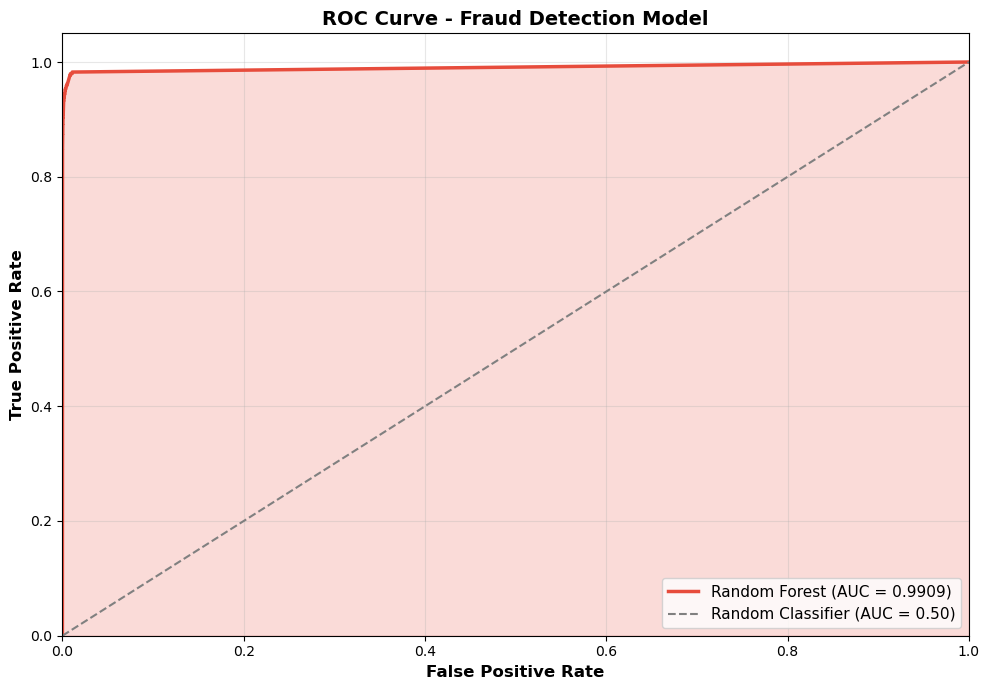

In [16]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='#e74c3c', linewidth=2.5, label=f'{best_model_name} (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', linewidth=1.5, label='Random Classifier (AUC = 0.50)')
plt.fill_between(fpr, tpr, alpha=0.2, color='#e74c3c')

plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('ROC Curve - Fraud Detection Model', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.tight_layout()
plt.show()

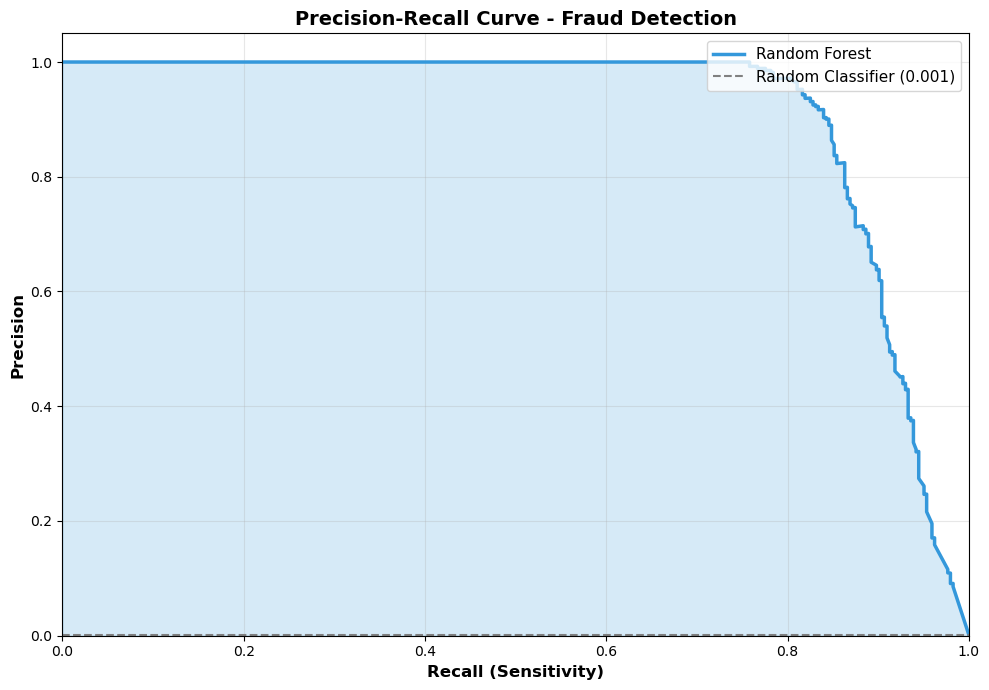

In [17]:
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_proba)

plt.figure(figsize=(10, 7))
plt.plot(recall, precision, color='#3498db', linewidth=2.5, 
         label=f'{best_model_name}')
plt.fill_between(recall, precision, alpha=0.2, color='#3498db')

# Baseline (random)
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', color='gray', 
         linewidth=1.5, label=f'Random Classifier ({no_skill:.3f})')

plt.xlabel('Recall (Sensitivity)', fontsize=12, fontweight='bold')
plt.ylabel('Precision', fontsize=12, fontweight='bold')
plt.title('Precision-Recall Curve - Fraud Detection', fontsize=14, fontweight='bold')
plt.legend(loc='upper right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.tight_layout()
plt.show()

In [ ]:
# Cross-validation
cv_scores = cross_val_score(best_model, X_train_scaled, y_train, cv=5, scoring='f1', n_jobs=-1)
print(f"F1-Scores: {cv_scores}")
print(f"Mean F1-Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

if hasattr(best_model, 'feature_importances_'):
    top_features = feature_importance.head(10)
    for idx, row in top_features.iterrows():
        print(f"{idx+1:2d}. {row['Feature']:<30s} {row['Importance']:.4f}")

In [ ]:
#Risk scoring function
def calculate_risk_score(model, transaction_features):
    risk_score = model.predict_proba(transaction_features)[0][1]
    if risk_score < 0.3:
        return {'score': risk_score, 'level': 'LOW', 'action': 'APPROVE'}
    elif risk_score < 0.7:
        return {'score': risk_score, 'level': 'MEDIUM', 'action': 'VERIFY'}
    elif risk_score < 0.9:
        return {'score': risk_score, 'level': 'HIGH', 'action': 'HOLD_FOR_REVIEW'}
    else:
        return {'score': risk_score, 'level': 'CRITICAL', 'action': 'BLOCK'}

In [ ]:
# Sample transaction
sample_transaction = X_test_scaled.iloc[0:1]
result = calculate_risk_score(best_model, sample_transaction)
print(f"  Risk Score: {result['score']:.4f}")
print(f"  Risk Level: {result['level']}")

# risk distribution
test_risk_scores = best_model.predict_proba(X_test_scaled)[:, 1]
risk_categories = pd.cut(test_risk_scores, bins=[0, 0.3, 0.7, 0.9, 1.0], labels=['LOW', 'MEDIUM', 'HIGH', 'CRITICAL'])

print(f"\nRisk Level Distribution in Test Set:")
print(risk_categories.value_counts().sort_index())

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(test_risk_scores, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].axvline(0.3, color='green', linestyle='--', linewidth=2, label='LOW threshold')
axes[0].axvline(0.7, color='orange', linestyle='--', linewidth=2, label='MEDIUM threshold')
axes[0].axvline(0.9, color='red', linestyle='--', linewidth=2, label='HIGH threshold')
axes[0].set_xlabel('Risk Score', fontweight='bold')
axes[0].set_ylabel('Frequency', fontweight='bold')
axes[0].set_title('Distribution of Risk Scores', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Risk category counts
risk_counts = risk_categories.value_counts().sort_index()
colors_risk = ['#2ecc71', '#f39c12', '#e67e22', '#e74c3c']
bars = axes[1].bar(risk_counts.index, risk_counts.values, color=colors_risk, 
                   edgecolor='black', alpha=0.8)
axes[1].set_ylabel('Number of Transactions', fontweight='bold')
axes[1].set_title('Transactions by Risk Level', fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
monitoring_metrics = {
    'Fraud Detection Rate': tp / (tp + fn) if (tp + fn) > 0 else 0,
    'False Positive Rate': fp / (fp + tn) if (fp + tn) > 0 else 0,
    'Precision': tp / (tp + fp) if (tp + fp) > 0 else 0,
    'Recall': tp / (tp + fn) if (tp + fn) > 0 else 0,
    'F1-Score': f1_score(y_test, y_pred),
    'Alert Accuracy': tp / (tp + fp) if (tp + fp) > 0 else 0,
    'Total Alerts': tp + fp,
    'True Frauds Caught': tp,
    'False Alarms': fp,
    'Missed Frauds': fn}

#Detection performance
for key in ['Fraud Detection Rate', 'False Positive Rate', 'Precision', 'Recall', 'F1-Score']:value = monitoring_metrics[key]
    print(f"{key:.<35s} {value:.2%}")

#Alert stats
for key in ['Total Alerts', 'True Frauds Caught', 'False Alarms', 'Missed Frauds']:value = monitoring_metrics[key]
    print(f"{key:.<35s} {value:,}")

print(f"{'Alert Accuracy':.<35s} {monitoring_metrics['Alert Accuracy']:.2%}")